# Total Energy Forecasting (3 Days without "Running")

### Libraries & Setup

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 2000)

### Data Loading & Preparation

74 columns dropped.
34 columns dropped: [' [TPE_0006.BarrelZone01_Act]', ' [TPE_0006.BarrelZone01_Set]', ' [TPE_0006.BarrelZone15_Act]', ' [TPE_0006.BarrelZone15_Set]', ' [TPE_0006.CoolingWater]', ' [TPE_0006.DosingUnit09_Act]', ' [TPE_0006.DosingUnit09_ActPercent]', ' [TPE_0006.DosingUnit09_FeederSpeed]', ' [TPE_0006.DosingUnit09_Set]', ' [TPE_0006.DosingUnit09_SetPercent]', ' [TPE_0006.DosingUnit10_Act]', ' [TPE_0006.DosingUnit10_ActPercent]', ' [TPE_0006.DosingUnit10_FeederSpeed]', ' [TPE_0006.DosingUnit10_Set]', ' [TPE_0006.DosingUnit10_SetPercent]', ' [TPE_0006.DosingUnitTotalizer10]', ' [TPE_0006.DosingUnitTotalizer9]', ' [TPE_0006.Filter]', ' [TPE_0006.Item_request_For_QualitySilo]', ' [TPE_0006.Item_response_For_QualitySilo]', ' [TPE_0006.MeltTemp01_Act]', ' [TPE_0006.Oil1Percent]', ' [TPE_0006.Oil1Totalizer]', ' [TPE_0006.Oil2Percent]', ' [TPE_0006.Oil2Totalizer]', ' [TPE_0006.OilFirstEnj]', ' [TPE_0006.OilFourthEnj]', ' [TPE_0006.OilSecondEnj]', ' [TPE_0006.OilThirdEnj]', ' [

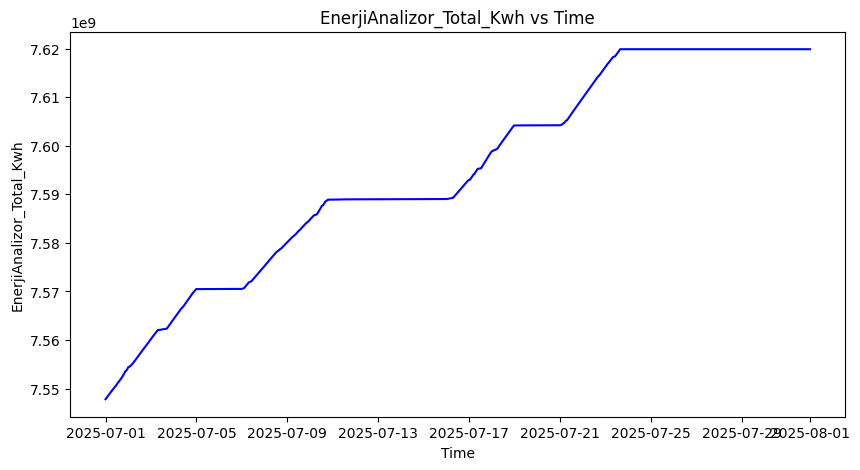

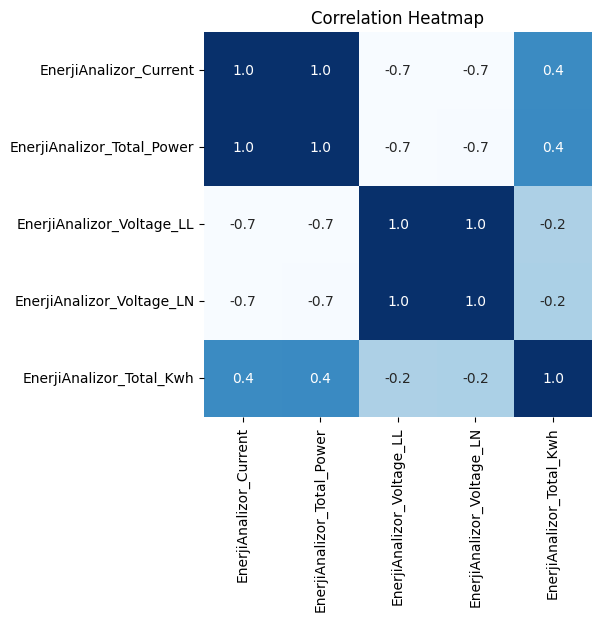

In [ ]:
# Data Loading
df = pd.read_csv("../data/tpe6_july_2025.csv")

# Convert DateTime column to datetime type and set as index
df["DateTime"] = pd.to_datetime(df["DateTime"], format="%m/%d/%y %H:%M")
df = df.set_index("DateTime")

# Drop columns with all missing values
missing_counts = df.isnull().sum()
cols_to_drop = missing_counts[missing_counts == 44640].index
df = df.drop(columns=cols_to_drop)
print(f"{len(cols_to_drop)} columns dropped.")

# Drop columns with a single unique value
unique_counts = df.nunique()
cols_to_drop = unique_counts[unique_counts == 1].index
df = df.drop(columns=cols_to_drop)
print(f"{len(cols_to_drop)} columns dropped: {list(cols_to_drop)}")

# Remove square brackets from column names
df.columns = df.columns.str.strip().str.replace("[", "").str.replace("]", "")

# Remove TPE 0006
df.columns = df.columns.str.replace(r"_TPE_\d+\.", "_", regex=True)
df.columns = df.columns.str.replace(r"TPE_\d+\.", "", regex=True)

df = df[[
    "EnerjiAnalizor_Current",
    "EnerjiAnalizor_Total_Power",
    "EnerjiAnalizor_Voltage_LL",
    "EnerjiAnalizor_Voltage_LN",
    "EnerjiAnalizor_Total_Kwh",
    #"Running"
]]

# Fill missing values in the "Running" column
# df["Running"] = df["Running"].fillna(method="bfill")

print(df.head())

# Plot EnerjiAnalizor_Total_Kwh vs Time
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["EnerjiAnalizor_Total_Kwh"], color="blue")
plt.title("EnerjiAnalizor_Total_Kwh vs Time")
plt.xlabel("Time")
plt.ylabel("EnerjiAnalizor_Total_Kwh")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(df.corr(), annot=True, cbar=False, cmap='Blues', fmt='.1f')
plt.title("Correlation Heatmap")
plt.show()


### Data Preprocessing

In [14]:
# Convert minute data to hourly
agg = {
    "EnerjiAnalizor_Current": "mean",
    "EnerjiAnalizor_Total_Power": "mean",
    "EnerjiAnalizor_Voltage_LL": "mean",
    "EnerjiAnalizor_Voltage_LN": "mean",
    "EnerjiAnalizor_Total_Kwh": "last",  # veya 'max'
    #"Running": lambda s: int(s.mean()>=0.5),  # veya 'min' / 'max'
}

df = df.resample("H").agg(agg).ffill()
# df["Running"] = df["Running"].astype(int)

In [15]:
# Instead of cumulative Kwh data, use Kwh difference data (hourly consumption)
df["EnerjiAnalizor_Kwh_Diff"] = df["EnerjiAnalizor_Total_Kwh"].diff().clip(lower=0).fillna(0)

# Reset Kwh difference data to zero when Running=0 (guarantee)
# df.loc[df["Running"] == 0, "EnerjiAnalizor_Kwh_Diff"] = 0

In [16]:
# Target and features
target = "EnerjiAnalizor_Kwh_Diff"
features = [c for c in df.columns if c not in ["EnerjiAnalizor_Total_Kwh", target]]

X_raw = df[features].values
y_raw = df[[target]].values

# Scale
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

In [17]:
# Create sequences
SEQ_LEN = 24    # past 24 hours
HORIZON = 72   # future 72 hours (3 days)

def create_sequences(X, y, seq_len, horizon):
    Xs, ys = [], []
    for i in range(len(X) - seq_len - horizon):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len:i+seq_len+horizon])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN, HORIZON)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

X_seq shape: (648, 24, 4)
y_seq shape: (648, 72, 1)


In [18]:
# Train/Test split
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

### Model Training

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, activation="tanh", input_shape=(SEQ_LEN, X_train.shape[2]), kernel_regularizer=l2(1e-4)),
    Dropout(0.1),
    LSTM(32, return_sequences=False, activation="tanh", kernel_regularizer=l2(1e-4)),
    Dropout(0.1),
    Dense(HORIZON)
])

model.compile(optimizer="adam", loss="mse")
model.summary()

es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=80, batch_size=16, validation_data=(X_test, y_test), callbacks=[es])

# Model Save
# model.save("../models/forecast_3days_lstm_model.keras")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 72)             │         2,376 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,456 (126.78 KB)

 Trainable params: 32,456 (126.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1628 - val_loss: 0.0700
Epoch 2/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1147 - val_loss: 0.1145
Epoch 3/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1042 - val_loss: 0.1028
Epoch 4/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0971 - val_loss: 0.1149
Epoch 5/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0954 - val_loss: 0.1673
Epoch 6/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0938 - val_loss: 0.1823
Epoch 7/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0925 - val_loss: 0.2087
Epoch 8/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0918 - val_loss: 0.1114
Epoch 9/80
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0893 - val_loss: 0.1350


### Model Evaluation

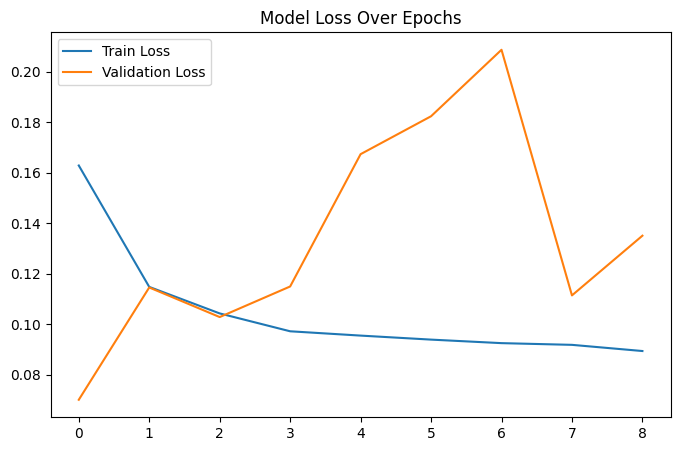

In [20]:
# Loss graph
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss Over Epochs")
plt.show()

In [21]:
# 3 days forecast
last_X = X_scaled[-SEQ_LEN:]
last_X = np.expand_dims(last_X, 0)

pred_scaled = model.predict(last_X)
pred_diff = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1))

# Return to cumulative
last_cum = df["EnerjiAnalizor_Total_Kwh"].iloc[-1]
pred_cum = last_cum + np.cumsum(pred_diff.flatten())

# Time index
last_date = df.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(hours=1), periods=HORIZON, freq="H")

forecast = pd.DataFrame({
    "Tahmin_Kwh_Diff": pred_diff.flatten(),
    "Tahmin_Kwh_Cum": pred_cum
}, index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


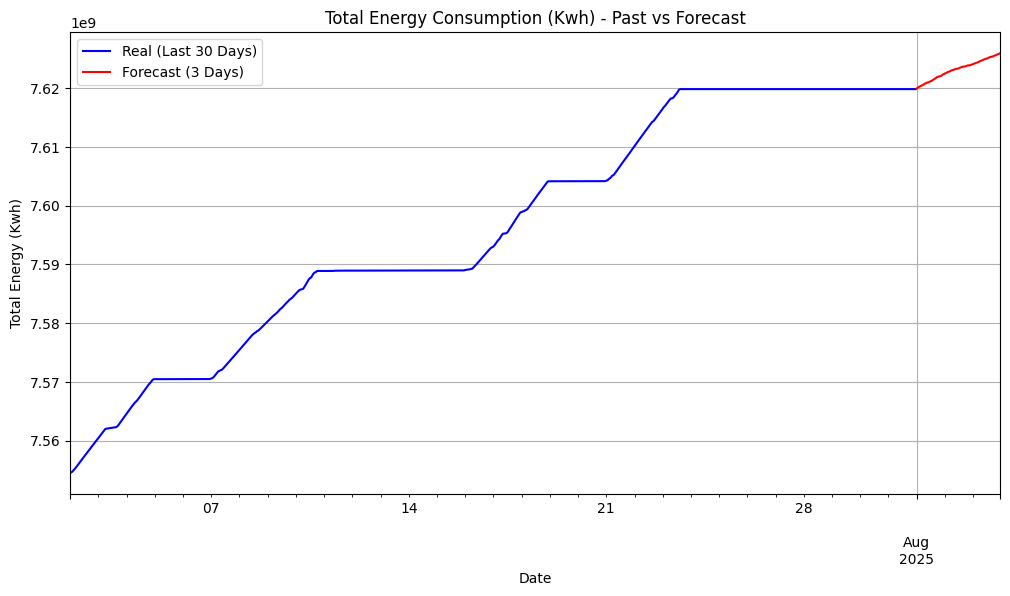

In [22]:
# Graph
plt.figure(figsize=(12,6))

# Real (last 30 days)
df["EnerjiAnalizor_Total_Kwh"].last("30D").plot(label="Real (Last 30 Days)", color="blue")

# Forecast (cumulative)
forecast["Tahmin_Kwh_Cum"].plot(label="Forecast (3 Days)", color="red")

plt.title("Total Energy Consumption (Kwh) - Past vs Forecast")
plt.xlabel("Date")
plt.ylabel("Total Energy (Kwh)")
plt.legend()
plt.grid(True)
plt.show()